# NLP - Author Attribution

## Identifying authors through excerpts

------

A notebook using Python alongside sklearn and NLTK to develop an NLP classifier. Given a collection of data on six Portuguese authors, we first analyze the data and take some general decisions on how to tackle the task. We make use of NLTK features to clean the data alongside some BASH scripts. The models are built and trained with sklearn.

Final predictions based on best model:

1000 word excerpts:

- testData/1000words/text1_clean.txt: joseSaramago
- testData/1000words/text2_clean.txt: almadaNegreiros
- testData/1000words/text3_clean.txt: luisaMarquesSilva
- testData/1000words/text4_clean.txt: ecaDeQueiros
- testData/1000words/text5_clean.txt: camiloCasteloBranco
- testData/1000words/text6_clean.txt: joseRodriguesSantos

500 word excerpts:

- testData/500words/text1_clean.txt: joseSaramago
- testData/500words/text2_clean.txt: almadaNegreiros
- testData/500words/text3_clean.txt: luisaMarquesSilva
- testData/500words/text4_clean.txt: ecaDeQueiros
- testData/500words/text5_clean.txt: camiloCasteloBranco
- testData/5000words/text6_clean.txt: joseRodriguesSantos

------
Authors: 
- Davide Montali M20190201
- Francisco Cruz M20190637
- Umberto Tammaro M20190806

Course: Text Mining -- Nova IMS

------

# Requirements and Imports

Please ensure you have the dependencies below installed and make sure to download the required NLTK data.

In [2]:
import pandas as pd
import numpy as np
import random
import nltk
import glob
import re
import shutil
from pathlib import Path

from itertools import count
import matplotlib.pyplot as plt

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [3]:
# Please make sure you have the following parts downloaded
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /home/d4ve/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/d4ve/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

# Normalising

We use a quick bash script to normalize the data. We first of all translate the data into ascii standard, to remove the various portuguese accents. Then we take the complement of the following set: 'A-Za-z0-9-,.!?"' - we decided to keep the punctuation given the varying use of punctuation by the different authors. We also lowercase the documents and merge them into a corpus document.

In [70]:
%%bash
unzip -q project-20200323.zip
rm -rf trainData testData cleanData
mkdir trainData testData cleanData
mv project/Corpora/train/* trainData/
mv project/Corpora/test/* testData/
rm -rf project/

In [71]:
%%bash
rm -rf trainData/*/*clean.txt
rm -rf trainData/*/corpus.txt
for dir in trainData/*/; do
    for book in $dir*.txt; do
        iconv -f utf8 -t ascii//TRANSLIT "$book" | tr -sc 'A-Za-z0-9-,.!?;:' ' ' | tr A-Z a-z  >> "${dir}corpus.txt"
    done
done

We also apply the same script to the data to be identified, although here for obvious reasons we don't concatenate the files into a corpus document.

In [72]:
%%bash
rm -rf testData/*/*clean.txt
for dir in testData/*/; do
    for book in $dir*.txt; do
        iconv -f utf8 -t ascii//TRANSLIT "$book" | tr -sc 'A-Za-z0-9-,.!?"' ' ' | tr A-Z a-z  > "${book%.*}"_clean.txt
    done
done

We define our functions used throughout the notebook as well as some variables we use. We also load the NLTK portuguese stemmer and stopwords.

In [73]:
def map_author(path):
    """Determine the author of a book through its file path."""
    for key, author in authors.items():
        if author.lower() in path.lower():
            return author
        
def clean_doc(doc, stopwords=True):
    doc = stem_doc(doc)
    if stopwords == True:
        doc = stop_doc(doc)
    return doc

def stem_doc(doc):
    """Takes a document, splits it up and stemms each word - then
    remerges the document together and returns it."""
    doc_split = doc.split()
    stem = [stemmer.stem(str(i)) for i in doc_split]
    doc = ' '.join(stem)
    return doc

def stop_doc(doc):
    """Takes a document and removes all stopwords from it"""
    doc_split = doc.split()
    temp = [i for i in doc_split if i not in stopwords]
    doc = ' '.join(temp)
    return doc

def clean_new_data(doc):
    doc = re.split(r'(\W+)', doc)
    doc = ' '.join(doc)
    doc = clean_doc(doc)
    return doc

unknown = glob.glob('testData/*/*clean.txt')
unknown.sort()

def predict_unknown(model):
    for doc in unknown:
        with open(doc) as file:
            file = [clean_new_data(file.read())]
            y = int(model.predict(file))
            print(f"{doc} --> {book_data.target_names[y]}")
            
def load_data(path='cleanData/', encoding="UTF-8"):
    book_data = load_files('cleanData/', encoding="UTF-8")
    
    # Split into train and test set
    X_train, X_dev, y_train, y_dev = train_test_split(book_data.data, book_data.target, train_size=0.9)
    return book_data, X_train, X_dev, y_train, y_dev
            
def tester(model):
    # Reload files - in case we're working with different data splits
    book_data, X_train, X_dev, y_train, y_dev = load_data()
    
    model.fit(X_train, y_train)
    
    predicted = model.predict(X_dev)
    print(np.mean(predicted == y_dev))
    
    predict_unknown(model)

authors = {
            1: "almadaNegreiros",
            2: "ecaDeQueiros",
            3: "joseSaramago",
            4: "camiloCasteloBranco",
            5: "joseRodriguesSantos",
            6: "luisaMarquesSilva"}

# NLTK Tools
stopwords = list(nltk.corpus.stopwords.words('portuguese'))
stemmer = nltk.stem.RSLPStemmer()

## Balancing

Given the large imbalance in terms of words per author we have, we decided to split the corpus of each author into a number of smaller documents. Below we split into 500 word documents - the same count as the shortest excerpts we are looking to predict.

We also decided to undersample our data - this is further motivated by the vast imbalance ratio between the different auhtors. We explored oversampling as well - but given that we would generate new data for our minority class on the already scarce data we have, we decided undersampling was a more sensible route.

We store our data in a separate folder, with documents within a subfolder named after the authors (our target variable) - using this format we can easily read our data into sklearn.

In [75]:
# Training data paths
corpora = glob.glob('trainData/*/corpus.txt')

# Create a function to split the data into smaller files, and save them to file
# use the sklearn dataset format - so later files can be worked with easily.

def trucate(paths, w_path='cleanData/', words=500, max_splits=300, verbose=True):
    """Truncate function takes a list of corpora paths, and splits them
    based on the parameters set. The default is to write the files to a new
    folder with the authors as subdirectories and splitting documents into 500
    word docs, with a maximum of 300 splits per author. -1 splits makes all splits
    possible, without undersampling""" 
    
    # Make sure previous splits are deleted, to avoid errors
    # regarding split numbers or max words
    try:
        shutil.rmtree(w_path)
    except:
        if verbose:
            print('Creating new folder for split.\n')
        
    for path in paths:
        if verbose:
            print(f'Segmenting {map_author(path)}:')
        
        corpus = None
        
        with open(path) as file:
            corpus = file.read()
        
        corpus = re.split(r'(\W+)', corpus)
        corpus_len = len(corpus)
        if verbose:
            print('Done.\n')
        
        if max_splits == -1:
            splits = corpus_len // words
            # Make sure we don't loose data due to floor division.
            if len(corpus) % words > 0: splits += 1
        elif len(corpus) // words < max_splits:
            splits = corpus_len // words
            # Make sure we don't loose data due to floor division.
            if len(corpus) % words > 0: splits += 1
        else:
            splits = max_splits
            
        # Check if directories exist, and except errors
        # in case they do, otherwise create them.
        path_auth = w_path + map_author(path)
        Path(path_auth).mkdir(parents=True, exist_ok=True)
        
        # Set filename with itertools
        filename = ("/corpus_part_%03i.txt" % i for i in count(1))
        
        # Randomly choose the split points
        split_points = random.sample(range(0, corpus_len, words), splits)
        for i in split_points:
            seg = ' '.join(corpus[i:(i+words)])
            seg = clean_doc(seg)
            seg = re.sub(' +', ' ', seg)
            with open(path_auth + next(filename), "w") as file:
                file.write(seg)
            
trucate(corpora, words=700, max_splits=300)

Segmenting almadaNegreiros:
Done.

Segmenting camiloCasteloBranco:
Done.

Segmenting joseRodriguesSantos:
Done.

Segmenting luisaMarquesSilva:
Done.

Segmenting joseSaramago:
Done.

Segmenting ecaDeQueiros:
Done.



## Load Data
With our cleaned and balanced data, we load the data into sklearn with the load_files function.

In [105]:
# Using sklearn load_data it will deduce the target variables
# from the folder names - in our case the authors

book_data, X_train, X_dev, y_train, y_dev = load_data()

## KNN Bayes


In [109]:
KNN_clf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1))),
    ('clf', KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute', leaf_size=30, p=2,
                                metric='cosine', metric_params=None, n_jobs=1)),])

KNN_clf.fit(X_train, y_train)

predicted = KNN_clf.predict(X_dev)
np.mean(predicted == y_dev)

0.9523809523809523

In [107]:
tester(KNN_clf)

0.9319727891156463
testData/1000Palavras/text1_clean.txt --> joseSaramago
testData/1000Palavras/text2_clean.txt --> almadaNegreiros
testData/1000Palavras/text3_clean.txt --> camiloCasteloBranco
testData/1000Palavras/text4_clean.txt --> ecaDeQueiros
testData/1000Palavras/text5_clean.txt --> camiloCasteloBranco
testData/1000Palavras/text6_clean.txt --> joseRodriguesSantos
testData/500Palavras/text1_clean.txt --> joseSaramago
testData/500Palavras/text2_clean.txt --> almadaNegreiros
testData/500Palavras/text3_clean.txt --> joseSaramago
testData/500Palavras/text4_clean.txt --> ecaDeQueiros
testData/500Palavras/text5_clean.txt --> camiloCasteloBranco
testData/500Palavras/text6_clean.txt --> joseRodriguesSantos


In [108]:
print(metrics.classification_report(y_dev, predicted, target_names=book_data.target_names))

                     precision    recall  f1-score   support

    almadaNegreiros       0.83      1.00      0.91        15
camiloCasteloBranco       0.98      0.94      0.96        47
       ecaDeQueiros       0.91      0.91      0.91        23
joseRodriguesSantos       1.00      0.83      0.91        30
       joseSaramago       0.84      1.00      0.91        21
  luisaMarquesSilva       1.00      1.00      1.00        11

           accuracy                           0.93       147
          macro avg       0.93      0.95      0.93       147
       weighted avg       0.94      0.93      0.93       147



## Naive Bayes

We split our data and fit the NB model with an sklearn pipeline.

In [136]:
# Use sklearn pipeline to create our NB classifier
NB_clf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1), 
                             token_pattern=r"(?u)\b\w\w+\b|!+|\?|\.+|,|-+|:|;")),
    ('clf', MultinomialNB(alpha=0.001)), # We add smoothing to our NB 
])

NB_clf.fit(X_train, y_train)

predicted = NB_clf.predict(X_dev)
np.mean(predicted == y_dev)

1.0

In [140]:
np.mean(cross_val_score(NB_clf, X_train, y_train, cv=10))

0.9840446449225075

To validate our score, we use sklearn crossvalidation on the training data. Thereafter, we use the model to predict the values of our aforemention excluded test set.

In [137]:
tester(NB_clf)

1.0
testData/1000Palavras/text1_clean.txt --> joseSaramago
testData/1000Palavras/text2_clean.txt --> almadaNegreiros
testData/1000Palavras/text3_clean.txt --> luisaMarquesSilva
testData/1000Palavras/text4_clean.txt --> ecaDeQueiros
testData/1000Palavras/text5_clean.txt --> camiloCasteloBranco
testData/1000Palavras/text6_clean.txt --> joseRodriguesSantos
testData/500Palavras/text1_clean.txt --> joseSaramago
testData/500Palavras/text2_clean.txt --> almadaNegreiros
testData/500Palavras/text3_clean.txt --> luisaMarquesSilva
testData/500Palavras/text4_clean.txt --> ecaDeQueiros
testData/500Palavras/text5_clean.txt --> camiloCasteloBranco
testData/500Palavras/text6_clean.txt --> joseRodriguesSantos


In [143]:
print(metrics.classification_report(y_dev, predicted, target_names=book_data.target_names))

                     precision    recall  f1-score   support

    almadaNegreiros       1.00      1.00      1.00        15
camiloCasteloBranco       1.00      1.00      1.00        47
       ecaDeQueiros       1.00      1.00      1.00        23
joseRodriguesSantos       1.00      1.00      1.00        30
       joseSaramago       1.00      1.00      1.00        21
  luisaMarquesSilva       1.00      1.00      1.00        11

           accuracy                           1.00       147
          macro avg       1.00      1.00      1.00       147
       weighted avg       1.00      1.00      1.00       147



In [113]:
metrics.confusion_matrix(y_dev, predicted)

array([[15,  0,  0,  0,  0,  0],
       [ 0, 47,  0,  0,  0,  0],
       [ 0,  0, 23,  0,  0,  0],
       [ 0,  0,  0, 30,  0,  0],
       [ 0,  0,  0,  0, 21,  0],
       [ 0,  0,  0,  0,  0, 11]])

## SVM 

In [144]:
SVM_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(alpha=0.01)),
])

SVM_clf.fit(X_train, y_train)

predicted = SVM_clf.predict(X_dev)
np.mean(predicted == y_dev)

0.9387755102040817

In [145]:
tester(SVM_clf)

0.9659863945578231
testData/1000Palavras/text1_clean.txt --> joseSaramago
testData/1000Palavras/text2_clean.txt --> almadaNegreiros
testData/1000Palavras/text3_clean.txt --> luisaMarquesSilva
testData/1000Palavras/text4_clean.txt --> ecaDeQueiros
testData/1000Palavras/text5_clean.txt --> camiloCasteloBranco
testData/1000Palavras/text6_clean.txt --> joseRodriguesSantos
testData/500Palavras/text1_clean.txt --> joseSaramago
testData/500Palavras/text2_clean.txt --> almadaNegreiros
testData/500Palavras/text3_clean.txt --> luisaMarquesSilva
testData/500Palavras/text4_clean.txt --> ecaDeQueiros
testData/500Palavras/text5_clean.txt --> camiloCasteloBranco
testData/500Palavras/text6_clean.txt --> joseRodriguesSantos


In [146]:
print(metrics.classification_report(y_dev, predicted, target_names=book_data.target_names))

                     precision    recall  f1-score   support

    almadaNegreiros       1.00      0.93      0.97        15
camiloCasteloBranco       0.98      0.89      0.93        47
       ecaDeQueiros       0.82      1.00      0.90        23
joseRodriguesSantos       1.00      0.90      0.95        30
       joseSaramago       0.88      1.00      0.93        21
  luisaMarquesSilva       1.00      1.00      1.00        11

           accuracy                           0.94       147
          macro avg       0.95      0.95      0.95       147
       weighted avg       0.95      0.94      0.94       147



In [147]:
metrics.confusion_matrix(y_dev, predicted)

array([[14,  0,  1,  0,  0,  0],
       [ 0, 42,  4,  0,  1,  0],
       [ 0,  0, 23,  0,  0,  0],
       [ 0,  1,  0, 27,  2,  0],
       [ 0,  0,  0,  0, 21,  0],
       [ 0,  0,  0,  0,  0, 11]])

## Dot dot dot

A Random Forest classifier, based solely on punctuation use of the authors.

In [278]:
from sklearn.ensemble import RandomForestClassifier

#trucate(corpora, words=2000, max_splits=100)

dot_clf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1),
                             token_pattern=r"(?u)!+|\?+|\.+|,+|-+|:|;")),
    ('clf', RandomForestClassifier(n_estimators=20, criterion='entropy')),
])

tester(dot_clf)

0.94
testData/1000Palavras/text1_clean.txt --> joseSaramago
testData/1000Palavras/text2_clean.txt --> joseRodriguesSantos
testData/1000Palavras/text3_clean.txt --> luisaMarquesSilva
testData/1000Palavras/text4_clean.txt --> ecaDeQueiros
testData/1000Palavras/text5_clean.txt --> camiloCasteloBranco
testData/1000Palavras/text6_clean.txt --> joseRodriguesSantos
testData/500Palavras/text1_clean.txt --> joseSaramago
testData/500Palavras/text2_clean.txt --> almadaNegreiros
testData/500Palavras/text3_clean.txt --> luisaMarquesSilva
testData/500Palavras/text4_clean.txt --> ecaDeQueiros
testData/500Palavras/text5_clean.txt --> joseSaramago
testData/500Palavras/text6_clean.txt --> joseRodriguesSantos


In [ ]:
def bencher(models, words, max_splits=[300], verbose=True):
    bench_scores = []
    models_list = ['KNN', 'NB', 'SVM', 'DOT']
    for w in words:
        for s in max_splits:
            trucate(corpora, w_path='cleanData/', words=w, max_splits=s, verbose=False)
            book_data, X_train, X_dev, y_train, y_dev = load_data()
            if verbose:
                print("\n\n___________________________")
                print(f"Running with {w} words and {s} splits:")
            for count, model in enumerate(models):
                model.fit(X_train, y_train)
                predicted = model.predict(X_dev)
                mean_cross = np.mean(cross_val_score(model, X_train, y_train, cv=10))
                mean_dev = np.mean(predicted == y_dev)
                bench_scores.append([models_list[count], mean_cross, mean_dev, w, s])
                if verbose:
                    print("cross val 10-fold: ", mean_cross)
                    print("accuracy on test: ",  mean_dev, "\n")
                
    df = pd.DataFrame(bench_scores, columns=['model', 'cross_val', 'test_accur', 'words', 'splits'])
    return df

options = [20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

df = bencher(words=options[:5],models=[KNN_clf, NB_clf, SVM_clf, dot_clf], verbose=False)

In [ ]:
import plotly.express as px
fig = px.line(df, x="words", y="test_accur", color="model", title="Dev Set Accuracy by Words", template="simple_white")
fig.update_layout(yaxis_title="dev set accuracy",
                xaxis_title="word count")
fig.show()

<IPython.core.display.Javascript object>


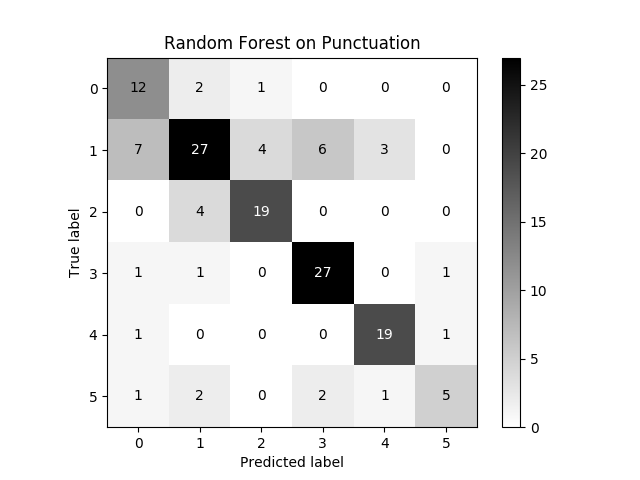

Text(0.5, 1.0, 'Random Forest on Punctuation')

In [279]:
%matplotlib notebook
labels = ["almadaNegreiros", "ecaDeQueiros", "joseSaramago",
          "camiloCasteloBranco", "joseRodriguesSantos", "luisaMarquesSilva"]
metrics.plot_confusion_matrix(dot_clf, X_dev, y_dev, cmap='gray_r')
plt.title("Random Forest on Punctuation")